#**LIBRARY**

In [ ]:
import json
import re
import string
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import tensorflow as tf

import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nlp_id.lemmatizer import Lemmatizer
from nlp_id.stopword import StopWord
from nlp_id.tokenizer import Tokenizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification
from wordcloud import WordCloud

import joblib

: 

In [ ]:
warnings.filterwarnings('ignore')
np.set_printoptions(precision=2, linewidth=80)

In [ ]:
# --- BAGIAN NLTK TANPA TRY-EXCEPT ---
# Mengunduh resource NLTK yang dibutuhkan secara langsung
print("Downloading NLTK 'punkt' tokenizer...")
nltk.download('punkt')

print("Downloading NLTK 'stopwords' corpus...")
nltk.download('stopwords')

print("Downloading NLTK 'wordnet' corpus...")
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

#**Data**

In [ ]:
df = pd.read_csv("/content/youtube-comments.csv")
df.columns = ["Time", "UserName", "Comment", "LikeCount"]
df.head()

,Time,UserName,Comment,LikeCount
0,2025-05-15T15:04:49Z,@fajarhamdani1134,Sangat betul...,0
1,2025-05-13T21:18:46Z,@SuponoPono-n5g,Ternak MULYONO manaaa ngertiiii......biangnya ...,0
2,2025-05-13T21:18:23Z,@SuponoPono-n5g,Ternak MULYONO manaaa ngertiiii......biangnya ...,0
3,2025-05-13T21:12:52Z,@SuponoPono-n5g,Ternak MULYONO manaaa ngertiiii......biangnya ...,0
4,2025-05-13T21:11:00Z,@SuponoPono-n5g,Ternak MULYONO manaaa ngertiiii......biangnya ...,0


#**DATA DESCRIPTION**

In [ ]:
print("Ukuran dataset:", df.shape)

Ukuran dataset: (19686, 4)


In [ ]:
print("\nInfo kolom:")
df.info()


Info kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19686 entries, 0 to 19685
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Time       19686 non-null  object
 1   UserName   19684 non-null  object
 2   Comment    19686 non-null  object
 3   LikeCount  19686 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 615.3+ KB


In [ ]:
df.describe()
print(df.describe())

          LikeCount
count  19686.000000
mean       3.239155
std      106.122095
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max    10225.000000


In [ ]:
print("\nCek Nilai Kosong:")
print(df.isnull().sum())


Cek Nilai Kosong:
Time         0
UserName     2
Comment      0
LikeCount    0
dtype: int64


In [ ]:
print("\nJumlah komentar unik:", df['Comment'].nunique())
print("Jumlah komentar duplikat:", df.duplicated('Comment').sum())


Jumlah komentar unik: 19297
Jumlah komentar duplikat: 389


#**CLEANING DATA**

In [ ]:
df = df.dropna()
print("\nSetelah menghapus nilai kosong:")
print(df.isnull().sum())


Setelah menghapus nilai kosong:
Time         0
UserName     0
Comment      0
LikeCount    0
dtype: int64


In [ ]:
df = df.drop_duplicates(subset="Comment", keep="first")
df.head()

,Time,UserName,Comment,LikeCount
0,2025-05-15T15:04:49Z,@fajarhamdani1134,Sangat betul...,0
1,2025-05-13T21:18:46Z,@SuponoPono-n5g,Ternak MULYONO manaaa ngertiiii......biangnya ...,0
5,2025-05-13T15:41:27Z,@BadariahAhmad-b7t,Kerja sawit di msia sudah middle upper class bro,0
6,2025-05-13T09:29:59Z,@mibaa7578,Seorang yg begitu bijak.. tahniah org muda.❤,0
7,2025-05-13T06:34:59Z,@RobiRahmathidayat01,Parah 😂,0


In [ ]:
with open('/content/combined_slang_words.txt') as f:
    data_slang = f.read()
formal_indo = json.loads(data_slang)
print("\nKamus normalisasi slang berhasil dimuat.")


Kamus normalisasi slang berhasil dimuat.


In [ ]:
def informal_to_formal_indo(text):
    if not formal_indo:
        return text
    res = " ".join(formal_indo.get(ele, ele) for ele in text.split())
    return(res)

# ADAPTASI: Menginisialisasi tokenizer, stopword, dan lemmatizer dari nlp_id
tokenizer_id = Tokenizer()
stopword_id = StopWord()
lemmatizer_id = Lemmatizer()

In [ ]:
def my_full_text_preprocessor(doc):
    # Membersihkan karakter khusus seperti di kode Anda
    doc = re.sub(r'@[A-Za-z0-9]+', '', doc) # Menghapus mention
    doc = re.sub(r'#[A-Za-z0-9]+', '', doc) # Menghapus hashtag
    doc = re.sub(r'RT[\s]', '', doc) # Menghapus RT
    doc = re.sub(r"http\S+", '', doc) # Menghapus URL
    doc = re.sub(r'[0-9]+', '', doc) # Menghapus angka
    doc = re.sub(r'(.)\1+',r'\1\1', doc) # Mengurangi pengulangan karakter (contoh: "halooolo" -> "halolo")
    doc = re.sub(r'[\?\.\!]+(?=[\?.\!])', '',doc) # Mengurangi pengulangan tanda baca (contoh: "????" -> "??")
    doc = re.sub(r'[^a-zA-Z]',' ', doc) # Hanya menyisakan huruf alfabet dan spasi
    doc = re.sub(r'\b(\w+)( \1\b)+', r'\1', doc) # Menghapus pengulangan kata (contoh: "baik baik" -> "baik")
    doc = doc.replace('\n', ' ') # Mengganti newline dengan spasi
    doc = doc.translate(str.maketrans('', '', string.punctuation)) # Menghapus tanda baca
    doc = doc.strip(' ') # Menghapus spasi di awal/akhir

    # Mengubah menjadi huruf kecil
    doc = doc.lower()

    # Text Normalization (kata slang)
    doc = informal_to_formal_indo(doc)

    # Punctuation Removal + Menghapus Angka (redundant setelah re.sub dan translate di atas, tapi biarkan untuk keamanan)
    doc = doc.translate(str.maketrans('', '', string.punctuation + string.digits))

    # Whitespace Removal
    doc = doc.strip()

    # Tokenization
    doc_tokens = tokenizer_id.tokenize(doc)

    # Stopwords Removal
    doc_tokens_no_stopwords = [word for word in doc_tokens if word not in stopword_id.get_stopword()]

    # Lemmatization
    doc_tokens_lemmatized = [lemmatizer_id.lemmatize(word) for word in doc_tokens_no_stopwords]

    return doc_tokens_lemmatized

In [ ]:
def stemming_list_of_words(list_of_words):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  stemmed_words = []
  for word in list_of_words:
    dt = stemmer.stem(word)
    stemmed_words.append(dt)
  d_clean = " ".join(stemmed_words) # Bergabung kembali menjadi string
  return d_clean

In [ ]:
df['preprocessing'] = df['Comment'].apply(my_full_text_preprocessor)
print("\nKolom 'Comment' setelah pre-processing (tokenized):")
print(df[['Comment', 'preprocessing']].head())

df['stemming_ulasan'] = df['preprocessing'].apply(stemming_list_of_words)
print("\nKolom 'preprocessing' setelah stemming:")
print(df[['preprocessing', 'stemming_ulasan']].head())


Kolom 'Comment' setelah pre-processing (tokenized):
                                             Comment  \
0                                    Sangat betul...   
1  Ternak MULYONO manaaa ngertiiii......biangnya ...   
5   Kerja sawit di msia sudah middle upper class bro   
6       Seorang yg begitu bijak.. tahniah org muda.❤   
7                                            Parah 😂   

                                       preprocessing  
0                                                 []  
1  [ternak, mulyono, manaa, ngertii, biang, gak, ...  
5  [kerja, sawit, msia, middle, upper, class, sau...  
6                        [bijak, tahniah, org, muda]  
7                                            [parah]  

Kolom 'preprocessing' setelah stemming:
                                       preprocessing  \
0                                                 []   
1  [ternak, mulyono, manaa, ngertii, biang, gak, ...   
5  [kerja, sawit, msia, middle, upper, class, sau...   
6              

###Sample Code

In [ ]:
df.to_csv('Youtube-Sentimen.csv', index=False)

print("File CSV berhasil disimpan.")

File CSV berhasil disimpan.


#**LABELING**

In [ ]:
def loadLexicon(file_path):
    with open(file_path, "r", encoding="utf-8", errors='replace') as f:
        data = f.readlines()
    return [d.strip().lower() for d in data]

In [ ]:
positif_words = loadLexicon("//content/positive_keyword.txt")
negatif_words = loadLexicon("//content/negative_keyword.txt")
negasi_words = loadLexicon("/content/negation.txt")
print("\nKamus leksikon bahasa Indonesia berhasil dimuat.")


Kamus leksikon bahasa Indonesia berhasil dimuat.


In [ ]:
def prediksiSentiment_lexicon(kalimat_str, positif_list, negatif_list, negasi_list):
    posWords = []
    negWords = []

    # Tokenisasi kalimat untuk pencarian kata. Asumsi input sudah distemming dan dijoin jadi string.
    words_in_sentence = kalimat_str.split()

    for i, word in enumerate(words_in_sentence):
        is_negated = False
        if i > 0 and words_in_sentence[i-1] in negasi_list:
            is_negated = True

        if word in positif_list:
            if is_negated:
                negWords.append(word) # Kata positif yang dinegasi dianggap negatif
            else:
                posWords.append(word)
        elif word in negatif_list:
            if not is_negated: # Kata negatif yang tidak dinegasi tetap negatif
                negWords.append(word)
            # Jika kata negatif dinegasi ("tidak buruk"), bisa jadi netral atau positif.
            # Untuk sederhana, kita biarkan tidak masuk ke negWords, cenderung netral.

    nPos, nNeg = len(posWords), len(negWords)

    if nPos > nNeg:
        return 'positif'
    elif nPos < nNeg:
        return 'negatif'
    else:
        return 'netral'

In [ ]:
df['label'] = df['stemming_ulasan'].apply(lambda x: prediksiSentiment_lexicon(x, positif_words, negatif_words, negasi_words))

print("\nDataset setelah pelabelan sentimen dengan leksikon:")
print(df[['Comment', 'stemming_ulasan', 'label']].head())


Dataset setelah pelabelan sentimen dengan leksikon:
                                             Comment  \
0                                    Sangat betul...   
1  Ternak MULYONO manaaa ngertiiii......biangnya ...   
5   Kerja sawit di msia sudah middle upper class bro   
6       Seorang yg begitu bijak.. tahniah org muda.❤   
7                                            Parah 😂   

                                     stemming_ulasan    label  
0                                                      netral  
1  ternak mulyono manaa ngertii biang gak jelaass...   netral  
5  kerja sawit msia middle upper class saudara la...  positif  
6                             bijak tahniah org muda  positif  
7                                              parah  negatif  



Distribusi Sentimen setelah pelabelan:
label
netral     7102
positif    6431
negatif    5762
Name: count, dtype: int64


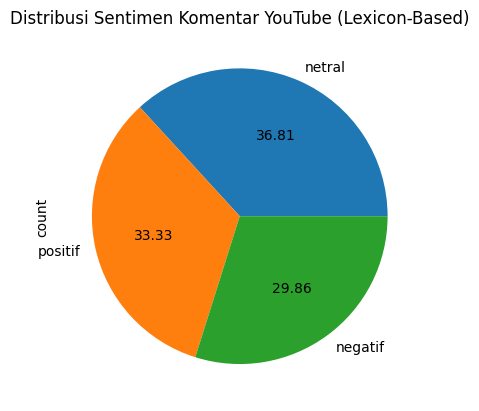

In [ ]:
print("\nDistribusi Sentimen setelah pelabelan:")
print(df['label'].value_counts())
df['label'].value_counts().plot.pie(autopct='%.2f')
plt.title("Distribusi Sentimen Komentar YouTube (Lexicon-Based)")
plt.show()

In [ ]:
df.replace(to_replace='negatif', value=0, inplace=True)
df.replace(to_replace='positif', value=1, inplace=True)
df.replace(to_replace='netral', value=2, inplace=True)
print("\nDataset setelah mengubah label menjadi numerik:")
print(df.head())

df['label'] = df['label'].astype(int)


Dataset setelah mengubah label menjadi numerik:
                   Time              UserName  \
0  2025-05-15T15:04:49Z     @fajarhamdani1134   
1  2025-05-13T21:18:46Z       @SuponoPono-n5g   
5  2025-05-13T15:41:27Z    @BadariahAhmad-b7t   
6  2025-05-13T09:29:59Z            @mibaa7578   
7  2025-05-13T06:34:59Z  @RobiRahmathidayat01   

                                             Comment  LikeCount  \
0                                    Sangat betul...          0   
1  Ternak MULYONO manaaa ngertiiii......biangnya ...          0   
5   Kerja sawit di msia sudah middle upper class bro          0   
6       Seorang yg begitu bijak.. tahniah org muda.❤          0   
7                                            Parah 😂          0   

                                       preprocessing  \
0                                                 []   
1  [ternak, mulyono, manaa, ngertii, biang, gak, ...   
5  [kerja, sawit, msia, middle, upper, class, sau...   
6                        [bij

In [ ]:
df.to_csv('Youtube-Sentimen.csv', index=False)

print("File CSV berhasil disimpan.")

File CSV berhasil disimpan.


In [4]:
df = pd.read_csv("//content/Youtube-Sentimen.csv")

#**DATA EXPLORATION**
Dibawah ini adalah beberapa contoh data yang bisa digunakan contohnya yaitu seperti panjang suatu komentar, jumlah komentar per hari, dan beberapa perbandingan yang bisa digunakan.

In [1]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment_indobert', palette='pastel')
plt.title('Distribusi Sentimen Komentar (IndoBERT)')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Komentar')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
df['comment_length'] = df['comment'].astype(str).apply(len)

plt.figure(figsize=(10,5))
sns.histplot(df['comment_length'], bins=50, kde=True)
plt.title('Distribusi Panjang Komentar')
plt.xlabel('Jumlah Karakter')
plt.ylabel('Frekuensi')
plt.show()

In [ ]:
if 'likes' in df.columns:
    plt.figure(figsize=(10,5))
    sns.boxplot(data=df, x='likes')
    plt.title('Distribusi Likes')
    plt.show()

In [ ]:
df['publishedAt'] = pd.to_datetime(df['publishedAt'], errors='coerce')

df['publishedAt'].dt.date.value_counts().sort_index().plot(kind='line', figsize=(10,5))
plt.title('Jumlah Komentar per Hari')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Komentar')
plt.grid(True)
plt.show()

In [ ]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

df[numeric_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle('Histogram dari Fitur Numerik')
plt.show()

In [ ]:
if len(numeric_cols) >= 2:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x=numeric_cols[0], y=numeric_cols[1])
    plt.title(f'Scatter Plot: {numeric_cols[0]} vs {numeric_cols[1]}')
    plt.show()

#**SPLITTING DATA**

In [ ]:
# ADAPTASI: Membagi data menjadi train, validation, dan test set untuk Indobert
data_for_indobert = df[['stemming_ulasan', 'label']]
df_train, df_test = train_test_split(data_for_indobert, test_size=0.2, random_state=42, stratify=data_for_indobert['label'])
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42, stratify=df_test['label']) # Split test into val and actual test

print('Training data shape:', df_train.shape)
print('Validation data shape:', df_val.shape)
print('Test data shape:', df_test.shape)

plt.figure(figsize=(5, 5))
sns.countplot(x=df_train['label'])
plt.title("Distribusi Label di Data Training")
plt.show()
df_train.to_csv('data_training_indobert.csv', index=False)

In [ ]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df_val['label'])
plt.title("Distribusi Label di Data Validasi")
plt.show()
df_val.to_csv('data_validasi_indobert.csv', index=False)

In [ ]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df_test['label'])
plt.title("Distribusi Label di Data Testing")
plt.show()
df_test.to_csv('data_testing_indobert.csv', index=False)

#**IndoBERT MODEL IMPLEMENTATION**

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

In [ ]:
print('Kalimat contoh:', df['stemming_ulasan'].iloc[0])
print('BERT Tokenizer:', bert_tokenizer.tokenize(df['stemming_ulasan'].iloc[0]))

In [ ]:
bert_input = bert_tokenizer.encode_plus(
    df['stemming_ulasan'].iloc[0],
    add_special_tokens=True,
    padding='max_length',
    truncation='longest_first',
    max_length=50,
    return_attention_mask=True,
    return_token_type_ids=True
)

In [ ]:
print('\nKeys from bert_input:', bert_input.keys())
print('Kalimat\t\t:', df['stemming_ulasan'].iloc[0])
print('Tokenizer\t:', bert_tokenizer.convert_ids_to_tokens(bert_input['input_ids']))
print('Input IDs\t:', bert_input['input_ids'])
print('Token Type IDs\t:', bert_input['token_type_ids'])
print('Attention Mask\t:', bert_input['attention_mask'])

In [ ]:
token_lens = []
for txt in df['stemming_ulasan']:
  tokens = bert_tokenizer.encode(txt)
  token_lens.append(len(tokens))

sns.histplot(token_lens, kde=True, stat='density', linewidth=0)
plt.xlim([0, 100])
plt.xlabel('Token count')
plt.title("Distribusi Panjang Token Komentar")
plt.show()

MAX_LENGTH = 50

In [ ]:
def convert_example_to_feature(sentence):
  return bert_tokenizer.encode_plus(
      sentence,
      add_special_tokens=True,
      padding='max_length',
      truncation='longest_first',
      max_length=MAX_LENGTH,
      return_attention_mask=True,
      return_token_type_ids=True
  )

def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

def encode_dataset(data_df):
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
  for sentence, label in data_df.to_numpy():
    bert_input = convert_example_to_feature(str(sentence)) # Pastikan input adalah string
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])
  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

train_encoded = encode_dataset(df_train).batch(32)
test_encoded = encode_dataset(df_test).batch(32)
val_encoded = encode_dataset(df_val).batch(32)

In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained(
    'indobenchmark/indobert-base-p2', num_labels=3) # 3 kelas: negatif, positif, netral

bert_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00003),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.keras.metrics.SparseCategoricalAccuracy('accuracy'))

print("\nMemulai pelatihan model IndoBERT...")
bert_history = bert_model.fit(train_encoded, epochs=5,
                              batch_size=32, validation_data=val_encoded)

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.title(f"Training and Validation {string.capitalize()}")
  plt.show()

plot_graphs(bert_history, 'accuracy')
plot_graphs(bert_history, 'loss')

print('\nEpoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss')
for i in range(len(bert_history.history['accuracy'])):
  print('{:8d} {:10f} \t {:10f} \t {:10f} \t {:10f}'.format(i + 1, bert_history.history['accuracy'][i],
                                                            bert_history.history['loss'][i],
                                                            bert_history.history['val_accuracy'][i],
                                                            bert_history.history['val_loss'][i]))

bert_model.save_weights('bert-model-youtube-sentiment.h5')
print("\nBobot model IndoBERT berhasil disimpan.")

#**MODELING**

In [ ]:
print("\nEvaluasi model IndoBERT pada data testing...")
score = bert_model.evaluate(test_encoded)
print(f"Test Accuracy: {score[1]:.4f}")

In [ ]:
predicted_raw = bert_model.predict(test_encoded)
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array([label for _, label_tensor in test_encoded for label in label_tensor.numpy().flatten()]) # Ekstrak label asli dari tf.data.Dataset

In [ ]:
print("\nAccuracy Score:", accuracy_score(y_true, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

# ADAPTASI: Menampilkan Classification Report dengan label yang benar
sentiment_labels_numeric = {0: 'negatif', 1: 'positif', 2: 'netral'}
y_true_named = np.array([sentiment_labels_numeric[val] for val in y_true])
y_pred_named = np.array([sentiment_labels_numeric[val] for val in y_pred])

print("\nClassification Report:\n", classification_report(y_true_named, y_pred_named, zero_division=0))

In [ ]:
confm = confusion_matrix(y_true, y_pred)
columns = ['negatif','positif','netral'] # Urutan ini harus cocok dengan mapping numerik 0, 1, 2
df_cm = pd.DataFrame(confm, index=columns, columns=columns)
ax = sns.heatmap(df_cm, cmap='Blues', annot=True, fmt='d')
ax.set_title('Confusion Matrix IndoBERT')
ax.set_xlabel('Label Prediksi')
ax.set_ylabel('Label Sebenarnya')
plt.show()

##Perbandingan Beberapa Metode

In [ ]:
models = {
    "LinearSVC": LinearSVC(random_state=42, max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42, n_estimators=100),
    "AdaBoost": AdaBoostClassifier(random_state=42, n_estimators=100),
    "SGD Classifier": SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
    "MLP Classifier": MLPClassifier(random_state=42, max_iter=300),
    "Dummy Classifier": DummyClassifier(strategy="most_frequent")
}

In [ ]:
results = {}

for name, model in models.items():
    print(f"\n--- Evaluasi Model: {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    }

    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['negative', 'neutral', 'positive'],
                yticklabels=['negative', 'neutral', 'positive'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

results_df = pd.DataFrame(results).T.sort_values(by='F1-Score', ascending=False)
print("\n Perbandingan Performa Model Klasifikasi:")
display(results_df.style.background_gradient(cmap='Blues').format("{:.2%}"))

##**GRADIENT BOOST**
Menggunakan model GRADIENT BOOST dikarenakan memiliki hasil akurasi yang paling tinggi.

In [ ]:
# Training model final (contoh: Gradient Boosting)
print("\n--- Training Final Model: Decision Tree ---")
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Evaluasi
print(f"Akurasi       : {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision     : {precision_score(y_test, y_pred, average='weighted'):.2f}")
print(f"Recall        : {recall_score(y_test, y_pred, average='weighted'):.2f}")
print(f"F1-Score      : {f1_score(y_test, y_pred, average='weighted'):.2f}")

In [ ]:
joblib.dump(model, 'sentiment_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

##**Prediksi komentar manual**

In [ ]:
# Load kembali model dan vectorizer (simulasi deployment)
model = joblib.load('sentiment_model.pkl')
vectorizer = joblib.load('vectorizer.pkl')

# Fungsi prediksi
def predict_sentiment(comment):
    cleaned = clean_text(comment)
    vect = vectorizer.transform([cleaned])
    pred = model.predict(vect)[0]
    return pred

In [ ]:
# Input komentar dari user
user_input = input("Masukkan komentar YouTube: ")
result = predict_sentiment(user_input)
print(f"\nSentimen prediksi: {result}")